In [4]:
import os
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [6]:
# Run this except for the first time
speeches_cleaned = pd.read_csv(os.path.join('.', 'presidential_speeches_cleaned.csv'), sep=',', encoding='utf8')
transcripts_copy = speeches_cleaned['Cleaned'].copy()

In [7]:
# Convert categorical variables to numeric
speeches_cleaned['Party'].replace({'Democratic': 0,'Republican': 1}, inplace=True)

In [8]:
vect = TfidfVectorizer(input='english') # input= is mandatory from v0.25 onwards!
transcripts_vect = vect.fit_transform(transcripts_copy)
transcripts_vect

<878x42059 sparse matrix of type '<class 'numpy.float64'>'
	with 780203 stored elements in Compressed Sparse Row format>

In [9]:
X_train, X_test, y_train, y_test = train_test_split(transcripts_vect, speeches_cleaned['Party'], test_size=0.2, random_state=42)

0.7670454545454546


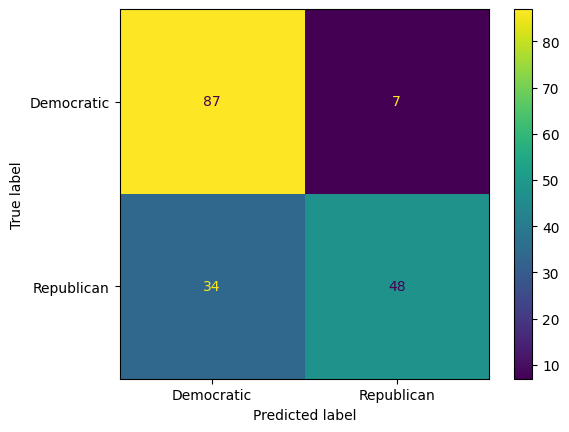

In [7]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)

print(accuracy_score(y_test, pred))
plot_confusion_matrix(logreg, X_test, y_test)

## SVM Classifier

In [20]:
svc_0 = SVC(random_state=42)

print('Parameters for svc_0 in use:\n', svc_0.get_params())

Parameters for svc_0 in use:
 {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False} 

Parameters for svc_1 in use:
 {'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'tol': 0.0001, 'verbose': 0}


In [21]:
# Create the parameter grid
C = [.0001, .001, .01, .1, 1, 10, 100]
degree = [1, 2, 3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel': ['linear'], 'probability': probability},
  {'C': C, 'kernel': ['poly'], 'degree': degree, 'probability': probability},
  {'C': C, 'kernel': ['rbf'], 'gamma': gamma, 'probability': probability}
]

# Create a base model
svc = SVC(random_state=42)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits=3, test_size =.2, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed: 22.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=42, test_size=0.2, train_size=None),
             estimator=SVC(random_state=42), n_jobs=-1,
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['linear'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'degree': [1, 2, 3, 4, 5], 'kernel': ['poly'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability': [True]}],
             scoring='accuracy', verbose=1)

In [22]:
print('The best hyperparameters from Grid Search are:\n', grid_search.best_params_)
print('\nThe mean accuracy of a model with these hyperparameters is:\n', grid_search.best_score_)

The best hyperparameters from Grid Search are:
 {'C': 10, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
 0.839243498817967


In [24]:
best_svc = grid_search.best_estimator_
best_svc.fit(X_train, y_train)

svc_pred = best_svc.predict(X_test)

# Test accuracy
print('Test accuracy:', accuracy_score(y_test, svc_pred))

Test accuracy: 0.7954545454545454


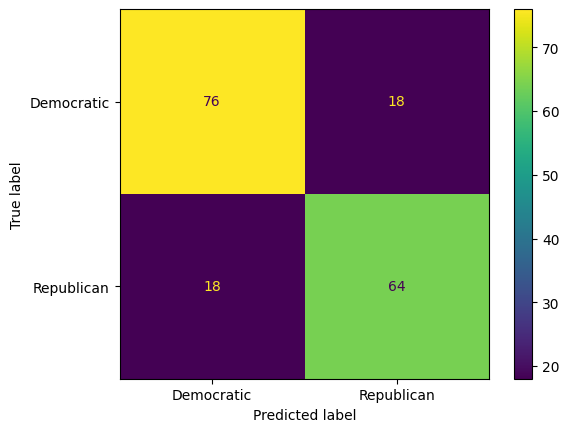

In [25]:
plot_confusion_matrix(best_svc, X_test, y_test)

In [28]:
print(classification_report(y_test, svc_pred))
scores = cross_val_score(estimator=best_svc, X=X_train, y=y_train, cv=10, scoring='f1_macro')
scores

              precision    recall  f1-score   support

  Democratic       0.81      0.81      0.81        94
  Republican       0.78      0.78      0.78        82

    accuracy                           0.80       176
   macro avg       0.79      0.79      0.79       176
weighted avg       0.80      0.80      0.80       176



array([0.9281522 , 0.79796748, 0.85119048, 0.94166667, 0.85119048,
       0.95642249, 0.89746809, 0.89746809, 0.77805961, 0.92784993])

## k Nearest Neighbors

In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

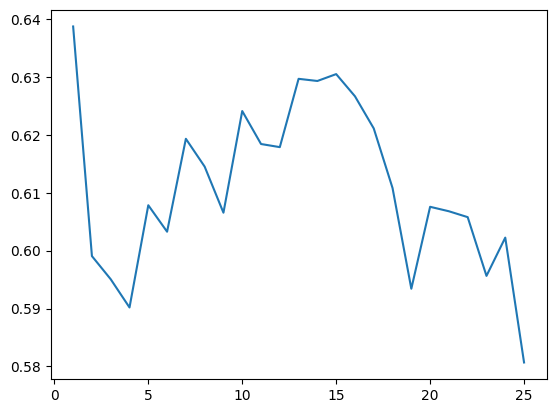

In [16]:
from sklearn.model_selection import RandomizedSearchCV

accuracies, params = [], []

for k in range(1, 26):
    params.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    pipe = make_pipeline(knn)
    scores = cross_val_score(pipe, transcripts_vect, speeches_cleaned['Party'], cv=10, scoring='f1_macro')
    accuracies.append(scores.mean())

plt.plot(params, accuracies)
plt.show()

0.8033802816901409 {'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.80      0.83      0.82        94
           1       0.80      0.77      0.78        82

    accuracy                           0.80       176
   macro avg       0.80      0.80      0.80       176
weighted avg       0.80      0.80      0.80       176



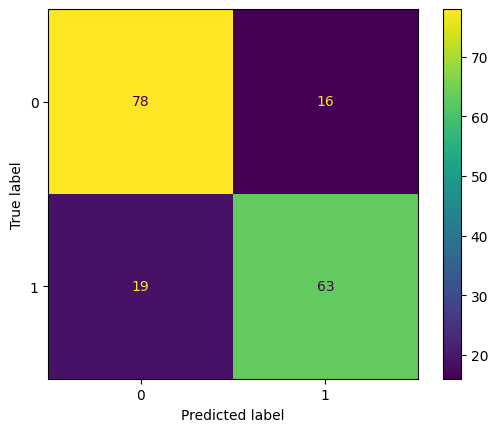

In [20]:
params = dict(n_neighbors=list(range(1, 26)))

rs_knn = RandomizedSearchCV(estimator=knn, param_distributions=params, scoring='accuracy', cv=10, n_jobs=-1, refit=True)
rs_knn.fit(X_train, y_train)

print(rs_knn.best_score_, rs_knn.best_params_)
knn_pred = rs_knn.best_estimator_.predict(X_test)
print(classification_report(y_test, knn_pred))
scores = cross_val_score(estimator=rs_knn, X=X_train, y=y_train, cv=10, scoring='accuracy')
plot_confusion_matrix(rs_knn, X_test, y_test)

## Deep Learning models

### Multivariate Logistic Regression

In [71]:
y_train.head()

290    0
685    1
547    1
833    1
770    1
Name: Party, dtype: int64

In [98]:
def vectorize_sequences(sequences, dim):
    results = np.zeros((len(sequences), dim))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results.astype('float32')

X_train_dl = vectorize_sequences(X_train.astype('int').todense(), 100)
X_test_dl = vectorize_sequences(X_test.astype('int').todense(), 100)

X_train_dl.shape, X_test_dl.shape

100

In [38]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

np.random.seed(1234)
tf.random.set_seed(1234)

In [79]:
deep1 = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[X_train_dl.shape[1]])])
optimizer = tf.keras.optimizers.SGD(0.1)
deep1.compile(loss='mean_squared_error',optimizer=optimizer)
history = deep1.fit(X_train_dl, y_train, epochs=100, batch_size=100)

Epoch 1/100
8/8 [==============================] - 1s 4ms/step - loss: 0.3397
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2613
Epoch 3/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2472
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2531
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2534
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2488
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2470
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2533
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2585
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2573
Epoch 11/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2469
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 0.2536
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

In [99]:
deep2 = tf.keras.models.Sequential()
deep2.add(tf.keras.layers.Input(shape=(100,)))
deep2.add(tf.keras.layers.Dense(500, activation='relu', name='hidden'))
deep2.add(tf.keras.layers.Dense(1, activation='sigmoid', name='affine'))

# sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
deep2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = deep2.fit(X_train_dl, y_train, epochs=20, validation_data=(X_test_dl, y_test), batch_size=500)

Epoch 1/20
2/2 [==============================] - 1s 590ms/step - loss: 0.6941 - accuracy: 0.4459 - val_loss: 0.6916 - val_accuracy: 0.5341
Epoch 2/20
2/2 [==============================] - 0s 36ms/step - loss: 0.6898 - accuracy: 0.5627 - val_loss: 0.6908 - val_accuracy: 0.5341
Epoch 3/20
2/2 [==============================] - 0s 39ms/step - loss: 0.6870 - accuracy: 0.5627 - val_loss: 0.6911 - val_accuracy: 0.5341
Epoch 4/20
2/2 [==============================] - 0s 45ms/step - loss: 0.6861 - accuracy: 0.5627 - val_loss: 0.6922 - val_accuracy: 0.5341
Epoch 5/20
2/2 [==============================] - 0s 43ms/step - loss: 0.6855 - accuracy: 0.5627 - val_loss: 0.6931 - val_accuracy: 0.5341
Epoch 6/20
2/2 [==============================] - 0s 41ms/step - loss: 0.6853 - accuracy: 0.5627 - val_loss: 0.6937 - val_accuracy: 0.5341
Epoch 7/20
2/2 [==============================] - 0s 52ms/step - loss: 0.6855 - accuracy: 0.5627 - val_loss: 0.6940 - val_accuracy: 0.5341
Epoch 8/20
2/2 [==========

In [100]:
loss, accuracy = deep2.evaluate(X_train_dl, y_train, verbose=False)
print('Training Accuracy: {:.4f}'.format(accuracy))
loss, accuracy = deep2.evaluate(X_test_dl, y_test, verbose=False)
print('Testing Accuracy:  {:.4f}'.format(accuracy))

Training Accuracy: 0.5627
Testing Accuracy:  0.5341


In [83]:
deep1.fit(x=X_train_dl, y=y_train, epochs=50)

Epoch 1/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2472
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2496
Epoch 3/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2505
Epoch 4/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2481
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2496
Epoch 6/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2478
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2481
Epoch 8/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2497
Epoch 9/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2476
Epoch 10/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2481
Epoch 11/50
22/22 [==============================] - 0s 3ms/step - loss: 0.2496
Epoch 12/50
22/22 [==============================] - 0s 2ms/step - loss: 0.2480
Epoch 13/50
22/22 [==============================

dict_keys(['loss'])


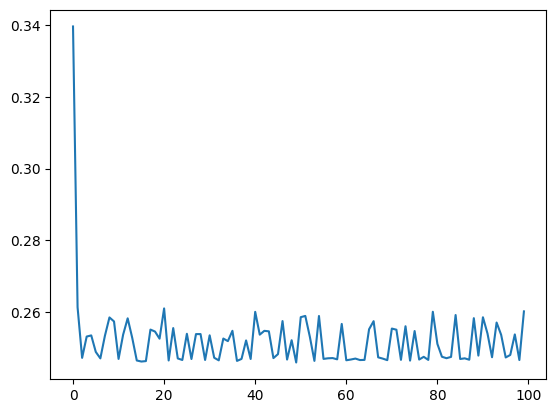

In [84]:
print(history.history.keys())
plt.plot(history.history['loss'])

In [86]:
from sklearn.metrics import mean_squared_error as mse

y_pred = deep1.predict(X_test_dl)
print(mse(y_test, y_pred))

0.2491660844874288


# # COOL STUFF FOR READ.ME

In [ ]:
speeches['President'].value_counts()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 14))
speeches['President'].value_counts(ascending=True).plot(kind='barh', color='blue')
plt.xlabel('Number of Speeches', fontsize=15)
plt.title('Number of Speeches per President', fontsize=20)
plt.tight_layout()

In [ ]:
speeches['Party'].value_counts(normalize=True).plot(kind='bar')